# Cat Vs Dogs

Dataset: [kaggle cat-and-dog](https://www.kaggle.com/tongpython/cat-and-dog)

In [1]:
# %cd nn-fooling/
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from dirimageloader import ImageLoader

In [2]:
iTrain = ImageLoader("/home/guest/DataSets/cat-and-dog/training_set")

# test set
iTest = ImageLoader("/home/guest/DataSets/cat-and-dog/test_set")

## Before Start Take A Look At The DataSet

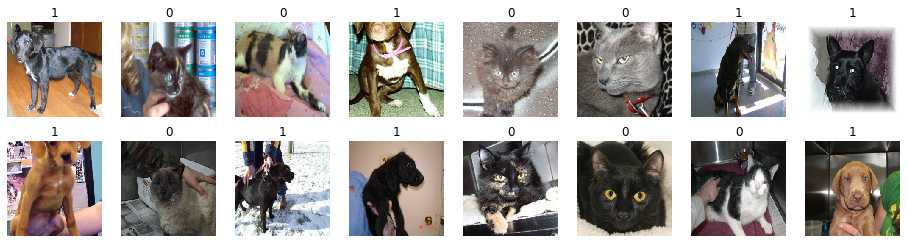

In [3]:
for p, l in iTrain.quick_iteration(diskbatch=16, listbatch=16, maxcount=16, useonehot=False, outformat="NHWC"):
    plt.figure(figsize=(16,4))
    for i, pi in enumerate(p):
        plt.subplot(2,8,i+1)
        plt.imshow(pi)
        plt.axis('off')
        plt.title(str(l[i]))
    plt.show()

## Precision and Recall

In [4]:
def precisionAndRecall(outbag, outman):
    
    pridbag = np.argmax(outbag, axis=1)
    pridman = np.argmax(outman, axis=1)

    TP = np.mean(pridman == 1)
    # act 0 prid 1
    FP = np.mean(pridbag == 1)
    # act 1 prid 0
    FN = np.mean(pridman == 0)
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    print("precision", P)
    print("recall   ", R)
    print("F1       ", 2 * P * R / (P + R))

## swish

$$
\text{h-swish}[x] = x \dfrac{\text{ReLU6}(x + 3)}{6}
$$

In [5]:
def h_swish(x):
    return x * nn.functional.relu6(x+3)/6

## Network structure

In [6]:
class CatDogs(nn.Module):
    def __init__(self, in_channels):
        super(CatDogs, self).__init__()
        self.conv00 = nn.Conv2d(in_channels, 6, (5,5), stride=2, padding=2)
        self.norm0x = nn.BatchNorm2d(6)
        
        self.conv10 = nn.Conv2d(6, 12, (3,3), stride=1, padding=0, groups=6)
        self.norm1x = nn.BatchNorm2d(12)
        self.pool11 = nn.MaxPool2d((3,3))
        
        self.conv20 = nn.Conv2d(12, 12, (5,5), stride=2, dilation=2, groups=6)
        self.pool21 = nn.AdaptiveAvgPool2d(1)
        self.linear22 = nn.Linear(12, 12)
        
        self.conv30 = nn.Conv2d(12, 9, (3,3), stride=2)
        self.norm30 = nn.BatchNorm2d(9)
        self.conv31 = nn.Conv2d(9, 9, (3,3), stride=2)
        self.pool31 = nn.AvgPool2d((3,3))
        self.linear32 = nn.Linear(9,2)
    
    def forward(self, x: torch.Tensor):
        out = self.conv00(x)
        out = self.norm0x(out)
        out = F.leaky_relu(out, 0.02, inplace=True)
        
        out = self.norm1x(self.conv10(out))
        out = self.pool11(out)
        out = F.leaky_relu(out, 0.002, inplace=True)
        # mask (N,9,H,W)
        pmask = self.pool21(out)[:,:,0,0]
        pmask = self.linear22(pmask)
        pmask = torch.sigmoid(pmask)
        # conv2-0 (N,9,H,W)
        out = self.conv20(out)
        out = out * pmask[:,:,None,None]
        out = F.leaky_relu(out, 0.02, inplace=True)
        
        out = self.conv30(out)
        out = self.norm30(out)
        out = F.relu(out)
        out = self.pool31(self.conv31(out))
        
        out = torch.squeeze(out)
        out = F.leaky_relu(out, 0.02, inplace=True)
        out = self.linear32(out)
        
        return out

$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                    \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$$

In [7]:
randx = torch.randn(4,3,224,224)

In [8]:
module = CatDogs(3)
module(randx).shape

torch.Size([4, 2])

## Loss Function And Optimizer

$$
L(y, \hat{y}) = - \sum_i y \log(\sigma(\hat{y}))
$$

$$
\sigma(x) = \dfrac{1}{1 + e^{-x}}
$$

In [9]:
def loss_calculate_bce(input, target):
    """
    output: (N,C,1,1)
    target: onehot (N,C)
    """
    input = torch.squeeze(input)
    # This criterion combines `log_softmax` and `nll_loss` in a single function.
    return nn.functional.cross_entropy(input, target)

## Train

In [10]:
cudamodel = CatDogs(3).cuda()

cudamodel.load_state_dict(torch.load("model-cat-vs-dogs.torch"))

optim = torch.optim.Adam(cudamodel.parameters(), lr=1e-3)

In [11]:
%matplotlib notebook

In [12]:
losses = []
accuracies = []

<IPython.core.display.Javascript object>


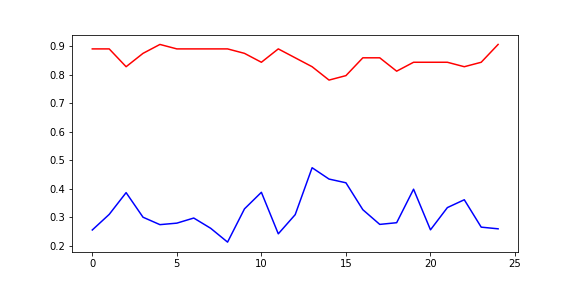

<IPython.core.display.Javascript object>


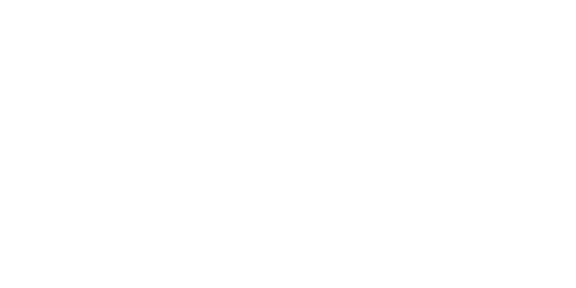

In [13]:
fig2 = plt.figure(figsize=(8,4))
fig2.show()
fig2ax = fig2.subplots(1,1)


for epho in range(1):
    for i, p, l in iTrain.quick_iteration(diskbatch=64, listbatch=32, isenum=True):        
        timage = torch.as_tensor(p, device=torch.device('cuda'))
        tlabel = torch.as_tensor(l, dtype=torch.int64, device=torch.device('cuda'))
        
        optim.zero_grad()
        out = cudamodel(timage)
        loss = nn.functional.cross_entropy(out, tlabel)
        loss.backward()
        optim.step()

        if i % 10 == 0:
            torch.save(cudamodel.state_dict(), "model-cat-vs-dogs.torch")
            
            predl = torch.argmax(out.cpu(), dim=1).numpy()
            losses.append(loss.cpu())
            accuracies.append(np.mean(predl == l))

            fig2ax.clear()
            fig2ax.plot(losses, 'b')
            fig2ax.plot(accuracies, 'r')
            
            fig2.canvas.draw()

In [14]:
torch.save(cudamodel.state_dict(), "model-cat-vs-dogs.torch")

## Evaluate

In [15]:
acc = []

for p, l in iTest.quick_iteration(diskbatch=64, listbatch=32):
    out = cudamodel(torch.Tensor(p).cuda())
    
    pred = torch.argmax(out, dim=1).cpu().numpy()
    
    acc.append(np.mean(l == pred))

print("test set acc", np.mean(acc))

test set acc 0.7953629032258065


# Fooling Images

We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

> [3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [16]:
import imageio

In [17]:
foolimg = np.stack([
    imageio.imread('./test-cat.jpg'),
    imageio.imread('./test-dog.jpg')
])


foolimg = foolimg.transpose(0,3,1,2).astype(np.float32) / 255

foolimg = torch.as_tensor(foolimg, device=torch.device('cuda'))
foolimg.requires_grad_(True)
print("foolimg", foolimg.shape)

out = cudamodel(foolimg)
print(out)
print(torch.argmax(out, dim=1))

foolimg torch.Size([2, 3, 224, 224])
tensor([[ 2.2293, -1.4608],
        [-1.2200,  1.4260]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([0, 1], device='cuda:0')


In [18]:
fakelabel_np = np.asarray([1,0])

fakelabel = torch.as_tensor(fakelabel_np, dtype=torch.int64).cuda()
fakelabel

tensor([1, 0], device='cuda:0')

Turn cats to dogs

In [19]:
while True:
    optim.zero_grad()
    out = cudamodel(foolimg)
    loss = nn.functional.cross_entropy(out, fakelabel)
    loss.backward()
    
    pred = torch.argmax(out, dim=1).cpu().numpy()
    
    print(f"predict {out.data.cpu().numpy().reshape(-1)}")
    
    if np.square(fakelabel_np - pred).sum() < 1e-8:
        break
    foolimg.data -= 5 * foolimg.grad / torch.sum(foolimg.grad*foolimg.grad)

predict [ 2.2292774 -1.4607964 -1.2200303  1.4260147]
predict [-0.99682605  0.38655946 -0.15959048  0.20624   ]
predict [-2.4603126  1.9008899  1.0066671 -0.8069264]


In [20]:
%matplotlib inline

In [21]:
fakeimgs = foolimg.data.cpu().numpy()
print(fakeimgs.shape)
fakeimgs = fakeimgs.transpose(0,2,3,1)
print(fakeimgs.shape)

(2, 3, 224, 224)
(2, 224, 224, 3)


In [22]:
out = cudamodel(foolimg)
torch.argmax(out, dim=1)

tensor([1, 0], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


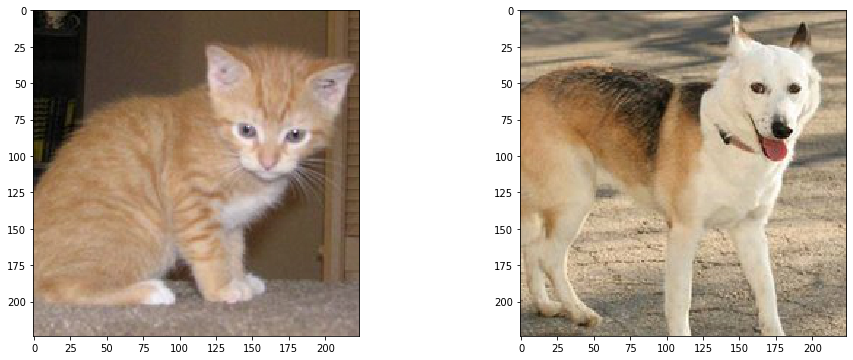

In [23]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(fakeimgs[0])
plt.subplot(1,2,2)
plt.imshow(fakeimgs[1])
plt.show()

## ^_^